# Cell Nuclei Separation using Watershed Algorithm

For this assignment, I'm working with the Data Science Bowl 2018 dataset to separate touching cell nuclei. The main challenge here is that when nuclei are close together or touching, they appear as one blob in the image. I'll be using the watershed algorithm, specifically comparing the standard approach with marker-controlled watershed to see how markers help prevent over-segmentation.

Let me start by setting up the environment and loading the data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, morphology, measure, segmentation, filters, feature
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 8)


output_dir = Path('results')
output_dir.mkdir(exist_ok=True)
print(f"Results will be saved to: {output_dir.resolve()}")


Results will be saved to: /home/patan/Downloads/archive/Nuclei/results


## Loading the Image

First, I need to load an image from the dataset. The Data Science Bowl dataset has images in the stage1_test folder. Let me pick one and see what we're working with.

Loading: f0d0ab13ff53adc3c4d57e95a5f83d80b06f2cbc0bf002b52cf7b496612e0ce4.png
Saved: results/01_original_image.png


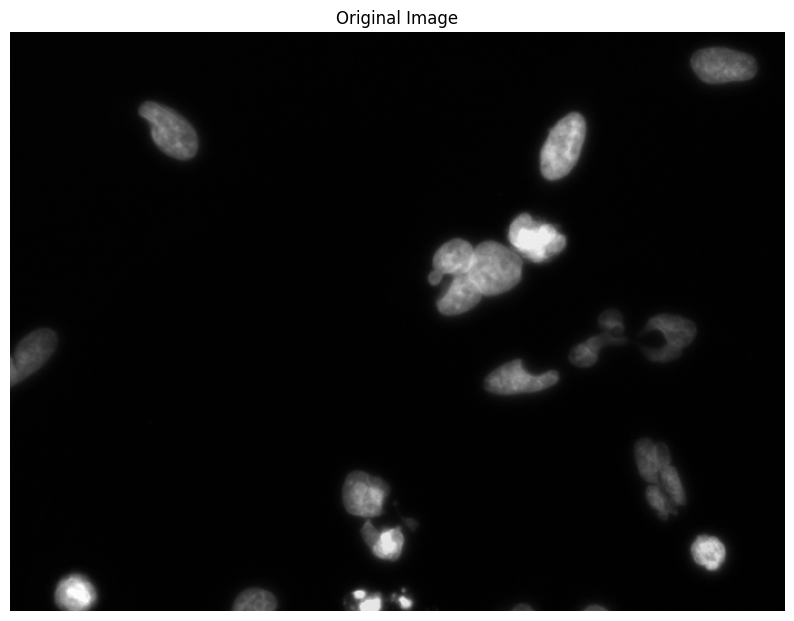

Image size: (520, 696)
Value range: 0.043 to 0.871


In [2]:
data_path = Path('/home/patan/Downloads/archive/Nuclei/DATA-SCIENCE-BOWL-2018/data')
test_path = data_path / 'stage1_test'

test_folders = [f for f in test_path.iterdir() if f.is_dir()]
if test_folders:
    sample_folder = test_folders[0]
    image_file = list((sample_folder / 'images').glob('*.png'))[0]
    
    print(f"Loading: {image_file.name}")
    
    img = io.imread(image_file)
    
    if len(img.shape) == 3:
        if img.shape[2] == 4:
            img = color.rgba2rgb(img)
        img_gray = color.rgb2gray(img)
    else:
        img_gray = img.copy()
    
    plt.figure(figsize=(10, 8))
    plt.imshow(img_gray, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    plt.savefig(output_dir / '01_original_image.png', dpi=150, bbox_inches="tight")
    print(f"Saved: {output_dir / '01_original_image.png'}")
    plt.show()
    
    print(f"Image size: {img_gray.shape}")
    print(f"Value range: {img_gray.min():.3f} to {img_gray.max():.3f}")
else:
    print("No test images found!")


Saved: results/02_preprocessing_steps.png


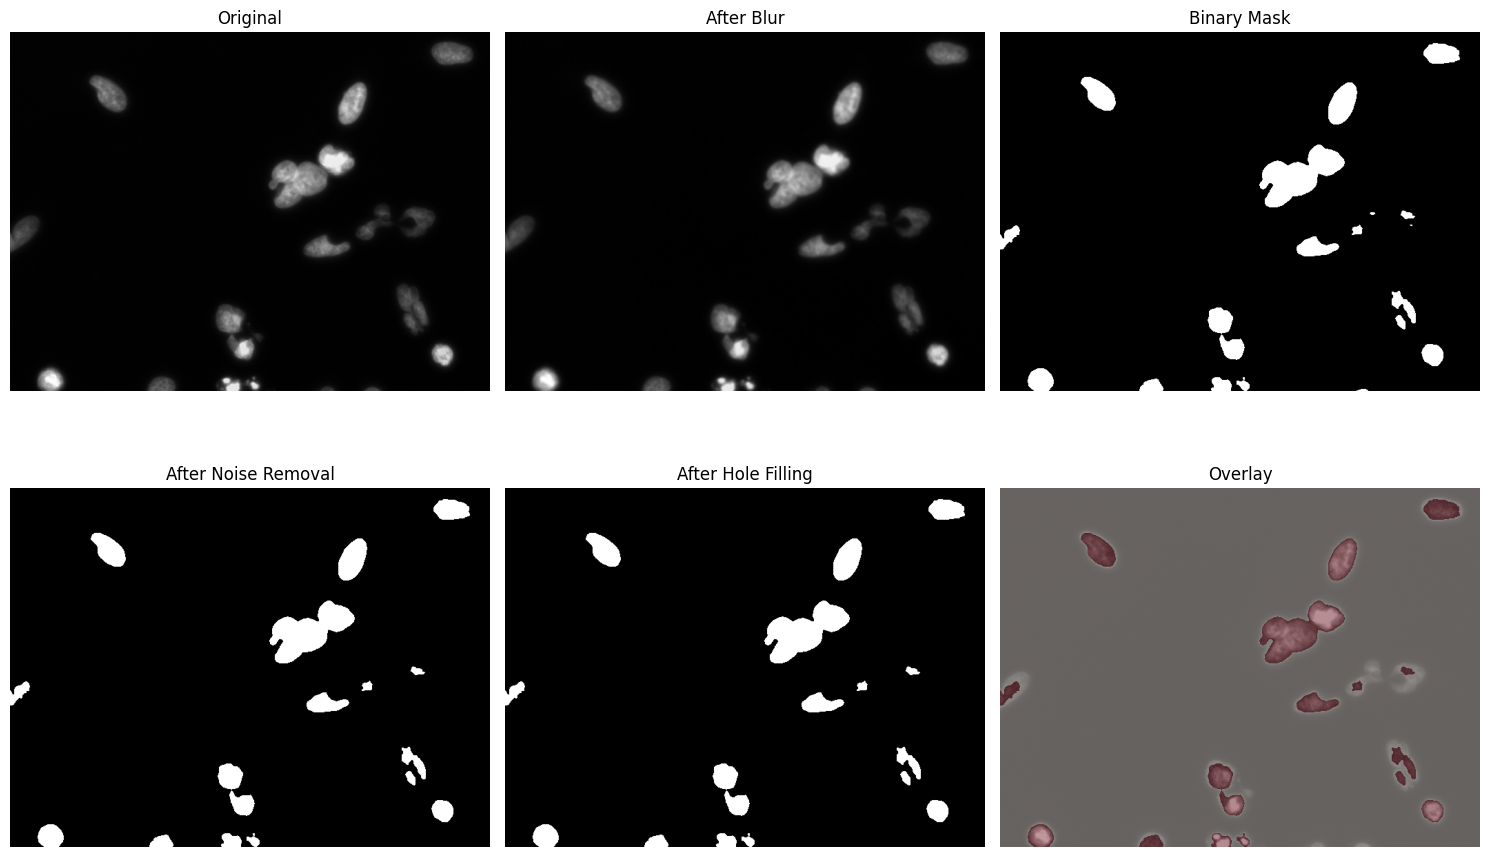

Connected components before watershed: 17


In [3]:
blurred = filters.gaussian(img_gray, sigma=1.0)

thresh = filters.threshold_otsu(blurred)
binary = blurred > thresh

if np.sum(binary) > binary.size * 0.5:
    binary = ~binary
    print("Inverted binary mask (nuclei are darker)")

binary_clean = morphology.remove_small_objects(binary, max_size=50)

binary_filled = ndimage.binary_fill_holes(binary_clean)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(img_gray, cmap='gray')
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

axes[0, 1].imshow(blurred, cmap='gray')
axes[0, 1].set_title('After Blur')
axes[0, 1].axis('off')

axes[0, 2].imshow(binary, cmap='gray')
axes[0, 2].set_title('Binary Mask')
axes[0, 2].axis('off')

axes[1, 0].imshow(binary_clean, cmap='gray')
axes[1, 0].set_title('After Noise Removal')
axes[1, 0].axis('off')

axes[1, 1].imshow(binary_filled, cmap='gray')
axes[1, 1].set_title('After Hole Filling')
axes[1, 1].axis('off')

axes[1, 2].imshow(img_gray, cmap='gray')
axes[1, 2].imshow(binary_filled, alpha=0.4, cmap='Reds')
axes[1, 2].set_title('Overlay')
axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig(output_dir / '02_preprocessing_steps.png', dpi=150, bbox_inches="tight")
print(f"Saved: {output_dir / '02_preprocessing_steps.png'}")
plt.show()

num_components = measure.label(binary_filled).max()
print(f"Connected components before watershed: {num_components}")


## 3. Watershed WITHOUT Markers (Standard Watershed)

This approach uses the distance transform as the input to watershed. It often leads to **over-segmentation** because every local minimum becomes a seed.

Saved: results/03_watershed_no_markers.png


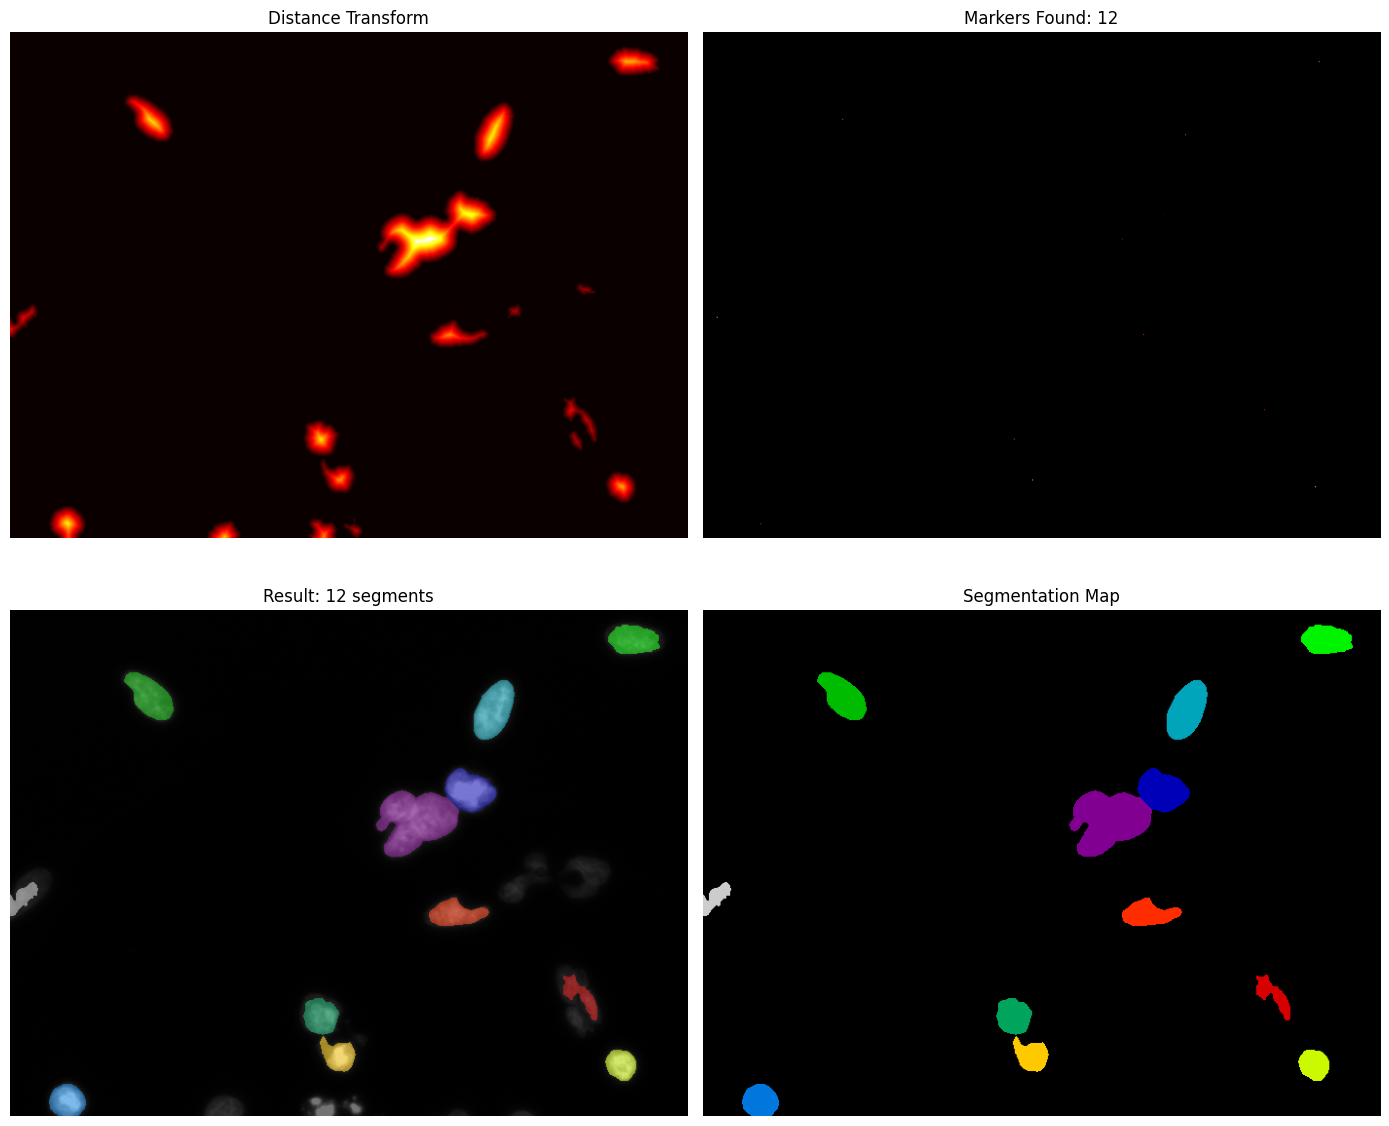

Segments found: 12
Notice: This might be over-segmented! Too many small regions.


In [4]:
distance = ndimage.distance_transform_edt(binary_filled)

local_max = feature.peak_local_max(distance, min_distance=10, threshold_abs=0.3*distance.max())

markers_no_control = np.zeros_like(distance, dtype=np.int32)
markers_no_control[tuple(local_max.T)] = np.arange(1, len(local_max) + 1)

labels_no_markers = watershed(-distance, markers=markers_no_control, mask=binary_filled)

num_segments_no_markers = len(np.unique(labels_no_markers)) - 1

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

axes[0, 0].imshow(distance, cmap='hot')
axes[0, 0].set_title('Distance Transform')
axes[0, 0].axis('off')

axes[0, 1].imshow(markers_no_control, cmap='nipy_spectral')
axes[0, 1].set_title(f'Markers Found: {len(local_max)}')
axes[0, 1].axis('off')

axes[1, 0].imshow(img_gray, cmap='gray')
axes[1, 0].imshow(labels_no_markers, alpha=0.5, cmap='nipy_spectral')
axes[1, 0].set_title(f'Result: {num_segments_no_markers} segments')
axes[1, 0].axis('off')

axes[1, 1].imshow(labels_no_markers, cmap='nipy_spectral')
axes[1, 1].set_title('Segmentation Map')
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig(output_dir / '03_watershed_no_markers.png', dpi=150, bbox_inches="tight")
print(f"Saved: {output_dir / '03_watershed_no_markers.png'}")
plt.show()

print(f"Segments found: {num_segments_no_markers}")
print("Notice: This might be over-segmented! Too many small regions.")


## 4. Watershed WITH Marker Control (Marker-Controlled Watershed)

This approach uses **carefully selected markers** to control the watershed process and prevent over-segmentation.

### Steps:
1. Find sure foreground (nuclei centers) using distance transform
2. Find sure background (boundaries)
3. Create markers from these regions
4. Apply watershed with controlled markers

In [5]:
min_dist = 20
thresh_abs = distance.max() * 0.3

local_maxima = peak_local_max(
    distance,
    min_distance=min_dist,
    threshold_abs=thresh_abs
)

markers = np.zeros_like(distance, dtype=np.int32)
markers[tuple(local_maxima.T)] = np.arange(1, len(local_maxima) + 1)

sure_bg = morphology.binary_dilation(binary_filled, morphology.disk(3))
sure_bg = ~sure_bg

# Mark sure background as 0 in markers (background label)
markers[sure_bg] = 0

labels_with_markers = watershed(-distance, markers=markers, mask=binary_filled)

num_segments_with_markers = len(np.unique(labels_with_markers)) - 1

print(f"Markers used: {len(local_maxima)}")
print(f"Segments found: {num_segments_with_markers}")


Markers used: 10
Segments found: 10


Saved: results/04_watershed_with_markers.png


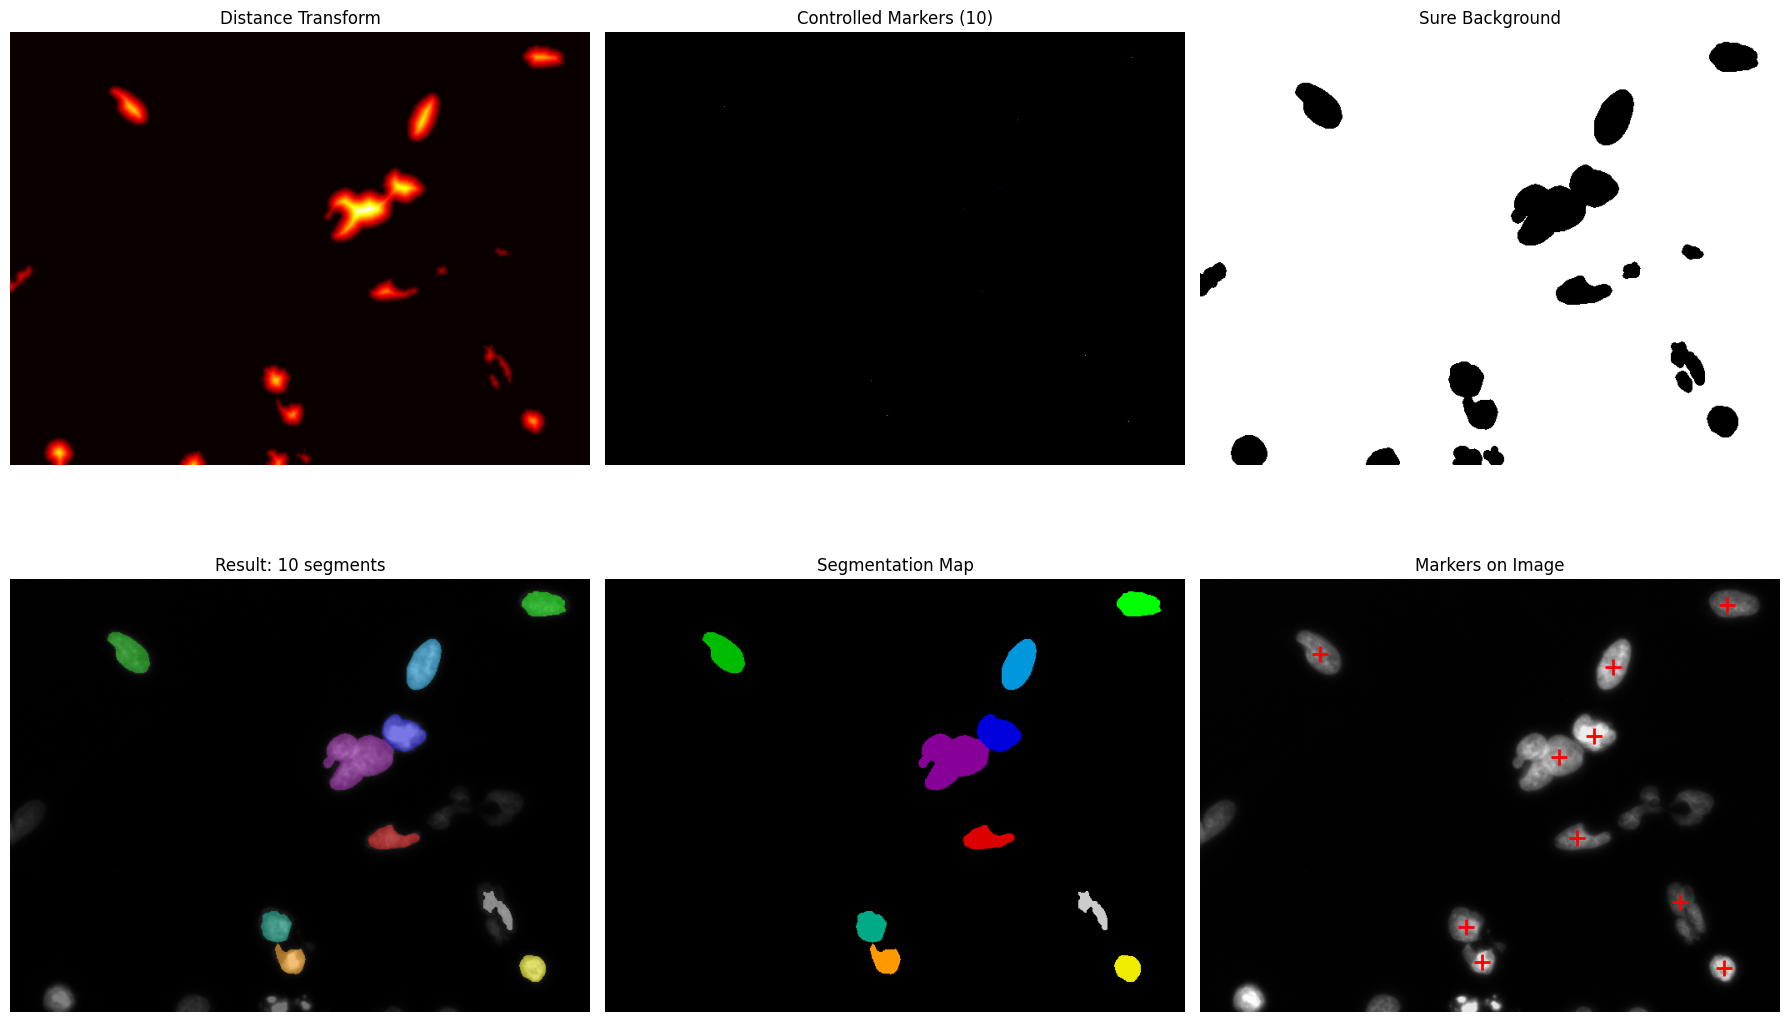

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

axes[0, 0].imshow(distance, cmap='hot')
axes[0, 0].set_title('Distance Transform')
axes[0, 0].axis('off')

axes[0, 1].imshow(markers, cmap='nipy_spectral')
axes[0, 1].set_title(f'Controlled Markers ({len(local_maxima)})')
axes[0, 1].axis('off')

axes[0, 2].imshow(sure_bg, cmap='gray')
axes[0, 2].set_title('Sure Background')
axes[0, 2].axis('off')

axes[1, 0].imshow(img_gray, cmap='gray')
axes[1, 0].imshow(labels_with_markers, alpha=0.5, cmap='nipy_spectral')
axes[1, 0].set_title(f'Result: {num_segments_with_markers} segments')
axes[1, 0].axis('off')

axes[1, 1].imshow(labels_with_markers, cmap='nipy_spectral')
axes[1, 1].set_title('Segmentation Map')
axes[1, 1].axis('off')

axes[1, 2].imshow(img_gray, cmap='gray')
marker_y, marker_x = np.where(markers > 0)
axes[1, 2].plot(marker_x, marker_y, 'r+', markersize=12, markeredgewidth=2)
axes[1, 2].set_title('Markers on Image')
axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig(output_dir / '04_watershed_with_markers.png', dpi=150, bbox_inches="tight")
print(f"Saved: {output_dir / '04_watershed_with_markers.png'}")
plt.show()


## Comparison: With vs Without Markers

Now let's compare the two approaches side by side. This should clearly show the difference - the marker-controlled approach should have fewer segments and better represent the actual nuclei.

Saved: results/05_comparison.png


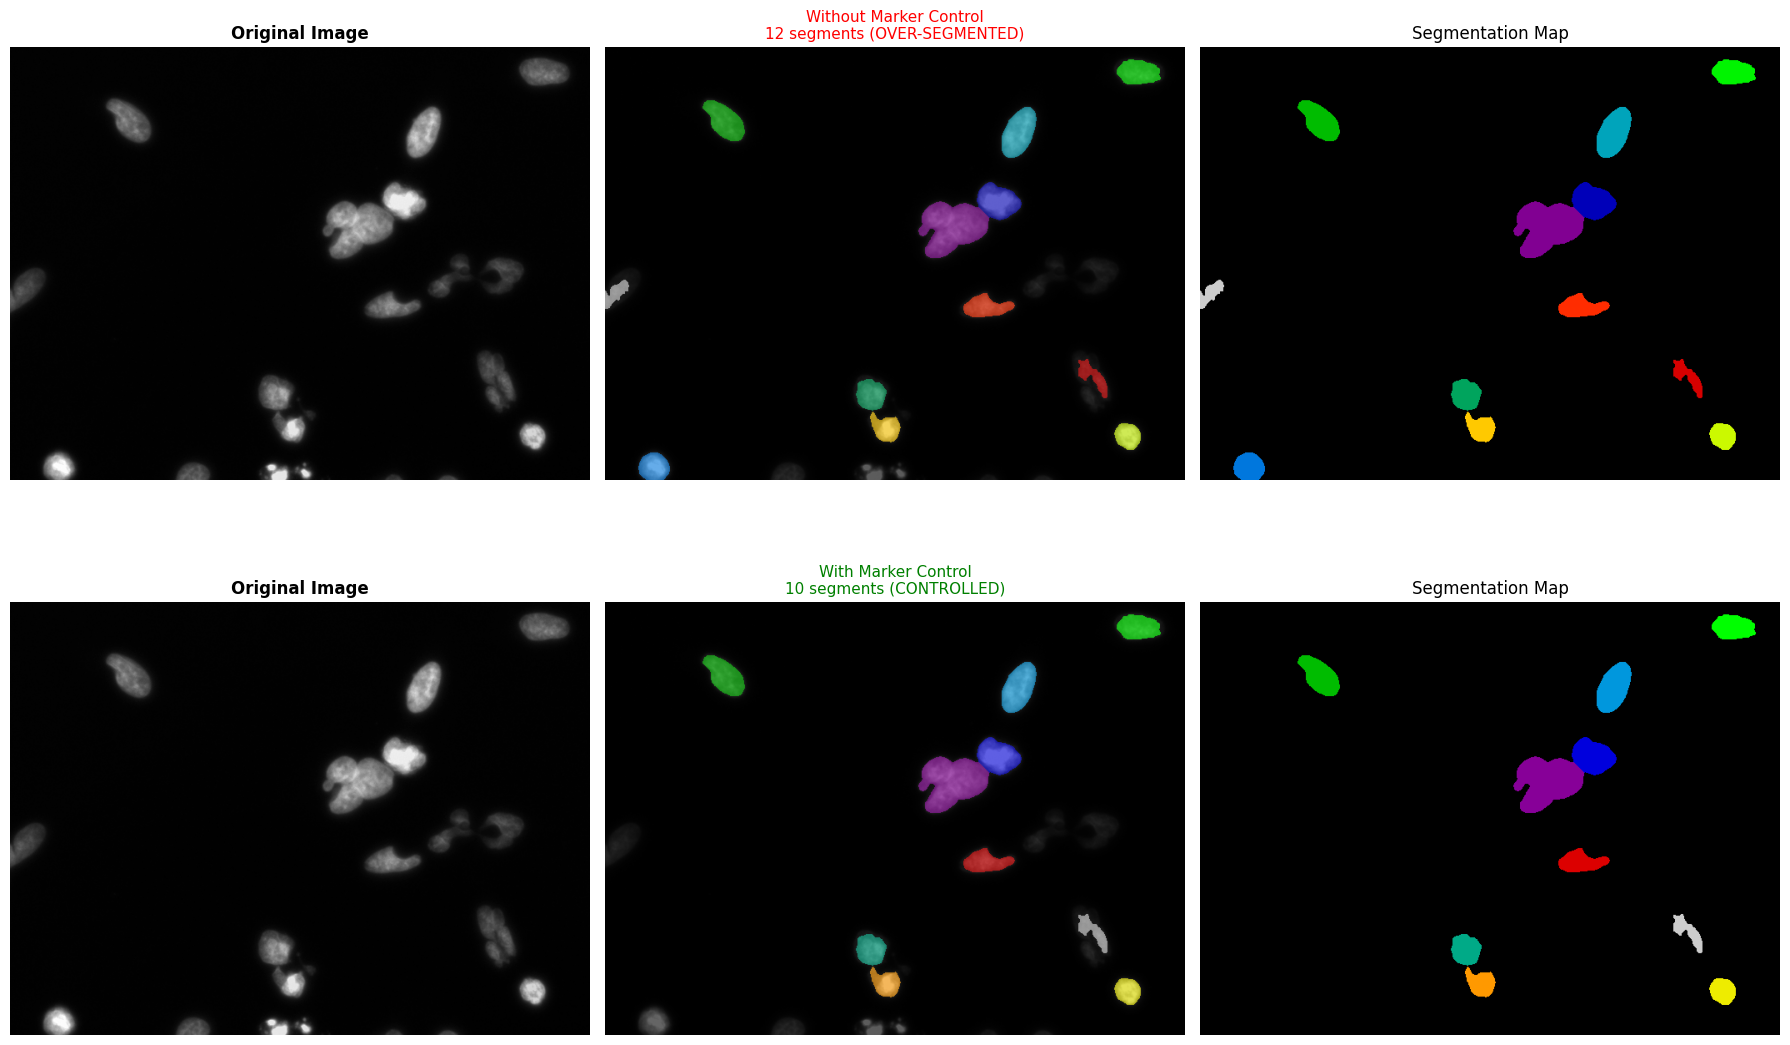


COMPARISON
Without markers: 12 segments
With markers:    10 segments
Difference:      2 segments
Reduction:        16.7%


In [7]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

axes[0, 0].imshow(img_gray, cmap='gray')
axes[0, 0].set_title('Original Image', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(img_gray, cmap='gray')
axes[0, 1].imshow(labels_no_markers, alpha=0.6, cmap='nipy_spectral')
axes[0, 1].set_title(f'Without Marker Control\n{num_segments_no_markers} segments (OVER-SEGMENTED)', 
                     fontsize=11, color='red')
axes[0, 1].axis('off')

axes[0, 2].imshow(labels_no_markers, cmap='nipy_spectral')
axes[0, 2].set_title('Segmentation Map')
axes[0, 2].axis('off')

axes[1, 0].imshow(img_gray, cmap='gray')
axes[1, 0].set_title('Original Image', fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(img_gray, cmap='gray')
axes[1, 1].imshow(labels_with_markers, alpha=0.6, cmap='nipy_spectral')
axes[1, 1].set_title(f'With Marker Control\n{num_segments_with_markers} segments (CONTROLLED)', 
                     fontsize=11, color='green')
axes[1, 1].axis('off')

axes[1, 2].imshow(labels_with_markers, cmap='nipy_spectral')
axes[1, 2].set_title('Segmentation Map')
axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig(output_dir / '05_comparison.png', dpi=150, bbox_inches="tight")
print(f"Saved: {output_dir / '05_comparison.png'}")
plt.show()

print("\n" + "="*50)
print("COMPARISON")
print("="*50)
print(f"Without markers: {num_segments_no_markers} segments")
print(f"With markers:    {num_segments_with_markers} segments")
print(f"Difference:      {num_segments_no_markers - num_segments_with_markers} segments")
if num_segments_no_markers > 0:
    reduction = ((num_segments_no_markers - num_segments_with_markers) / num_segments_no_markers) * 100
    print(f"Reduction:        {reduction:.1f}%")
print("="*50)


## Looking at Individual Nuclei

Let me extract some individual nuclei from the marker-controlled segmentation to see how well it worked.

Total nuclei detected: 10
Average area: 1465.1 pixels
Area range: 681.0 - 3889.0 pixels
Saved: results/06_individual_nuclei.png


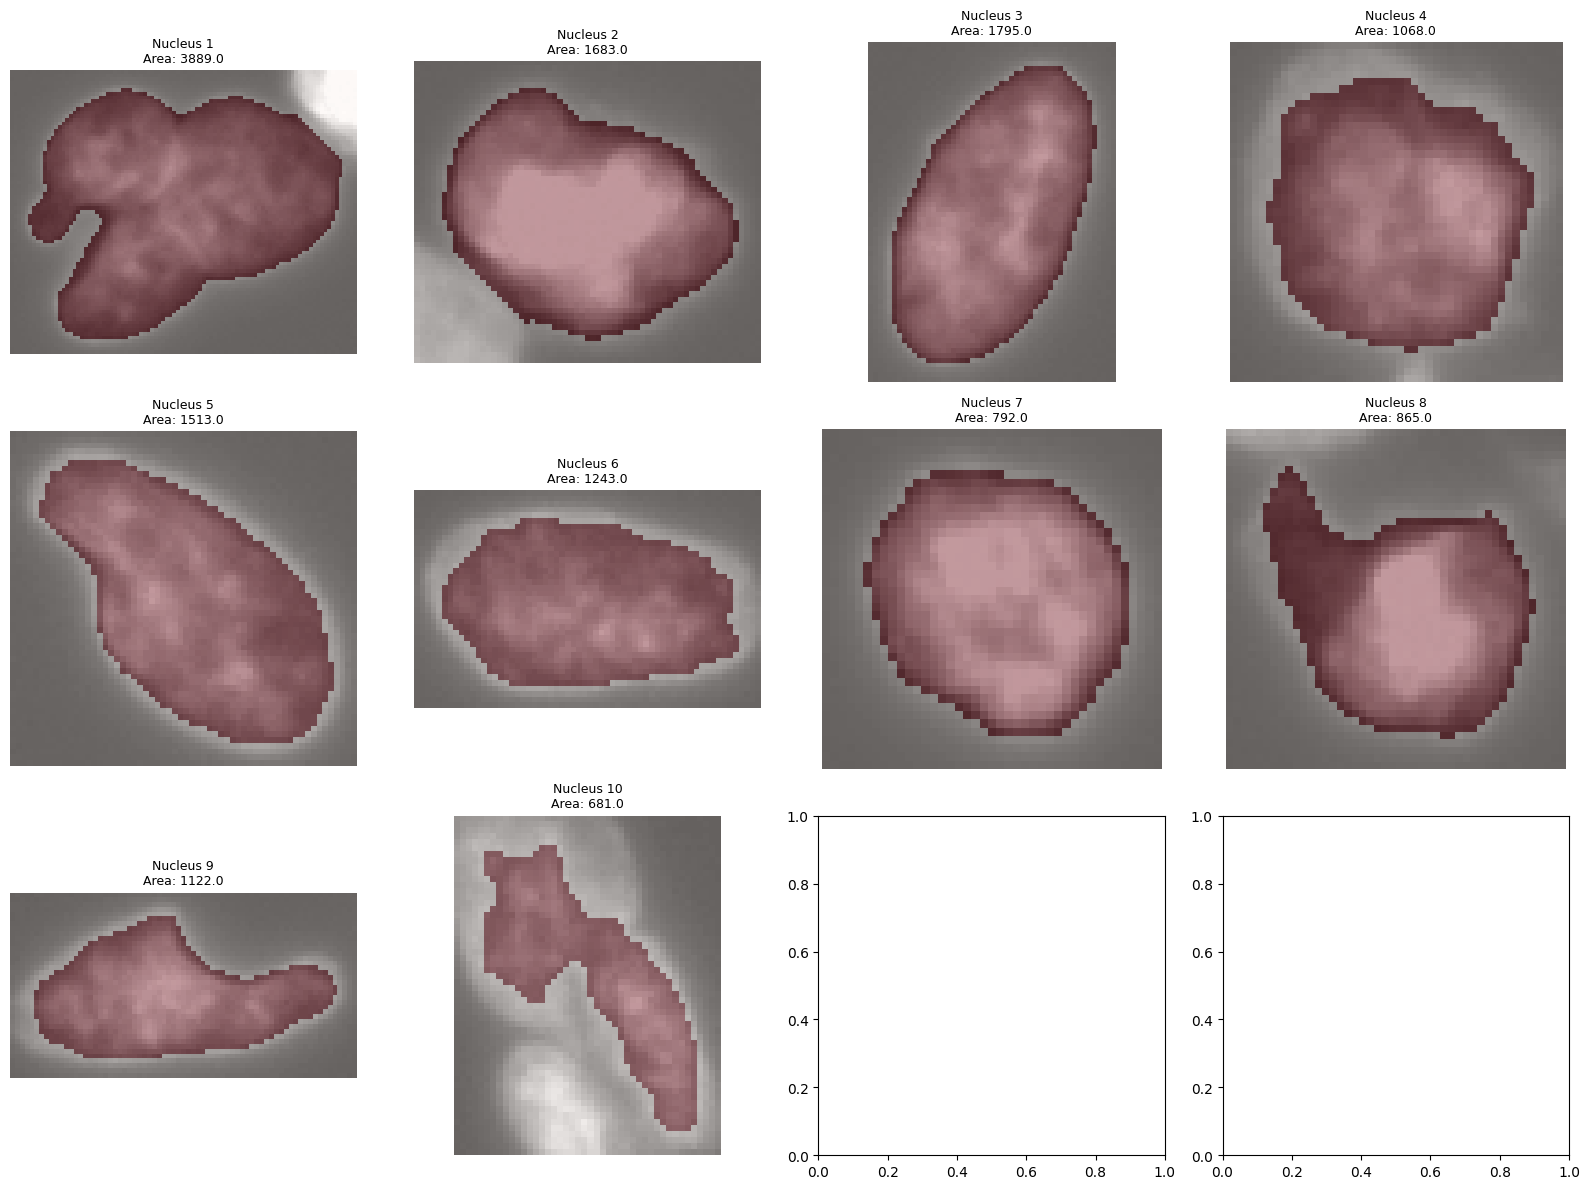

In [8]:
props = measure.regionprops(labels_with_markers)

nuclei_info = []
for prop in props:
    nuclei_info.append({
        'label': prop.label,
        'area': prop.area,
        'centroid': prop.centroid
    })

print(f"Total nuclei detected: {len(nuclei_info)}")
if len(nuclei_info) > 0:
    areas = [n['area'] for n in nuclei_info]
    print(f"Average area: {np.mean(areas):.1f} pixels")
    print(f"Area range: {np.min(areas)} - {np.max(areas)} pixels")

num_to_show = min(12, len(nuclei_info))
if num_to_show > 0:
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.flatten()

    for i, nucleus in enumerate(nuclei_info[:num_to_show]):
        label_id = nucleus['label']
        mask = labels_with_markers == label_id
        
        y, x = np.where(mask)
        if len(y) > 0:
            y_min, y_max = y.min(), y.max()
            x_min, x_max = x.min(), x.max()
            
            pad = 5
            y_min = max(0, y_min - pad)
            y_max = min(img_gray.shape[0], y_max + pad)
            x_min = max(0, x_min - pad)
            x_max = min(img_gray.shape[1], x_max + pad)
            
            region = img_gray[y_min:y_max, x_min:x_max]
            region_mask = mask[y_min:y_max, x_min:x_max]
            
            axes[i].imshow(region, cmap='gray')
            axes[i].imshow(region_mask, alpha=0.4, cmap='Reds')
            axes[i].set_title(f'Nucleus {label_id}\nArea: {nucleus["area"]}', fontsize=9)
            axes[i].axis('off')

    plt.tight_layout()
    plt.savefig(output_dir / '06_individual_nuclei.png', dpi=150, bbox_inches="tight")
    print(f"Saved: {output_dir / '06_individual_nuclei.png'}")
    plt.show()


Testing on another image...
Saved: results/07_second_image_result.png


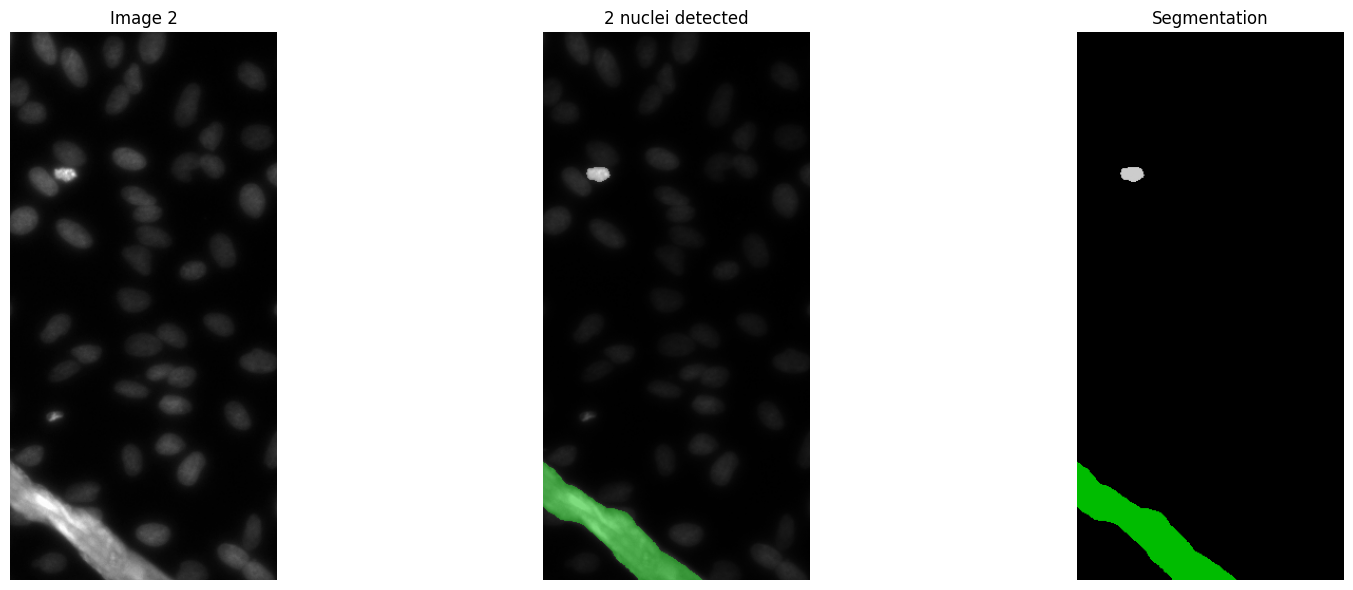

In [9]:
def separate_nuclei(image_path, min_distance=20, threshold_factor=0.3, sigma=1.0):
    img = io.imread(image_path)
    if len(img.shape) == 3:
        if img.shape[2] == 4:
            img = color.rgba2rgb(img)
        img_gray = color.rgb2gray(img)
    else:
        img_gray = img.copy()
    
    blurred = filters.gaussian(img_gray, sigma=sigma)
    thresh = filters.threshold_otsu(blurred)
    binary = blurred > thresh
    if np.sum(binary) > binary.size * 0.5:
        binary = ~binary
    binary_clean = morphology.remove_small_objects(binary, max_size=50)
    binary_filled = ndimage.binary_fill_holes(binary_clean)
    
    distance = ndimage.distance_transform_edt(binary_filled)
    
    thresh_abs = distance.max() * threshold_factor
    local_maxima = peak_local_max(
        distance,
        min_distance=min_distance,
        threshold_abs=thresh_abs
    )
    
    markers = np.zeros_like(distance, dtype=np.int32)
    markers[tuple(local_maxima.T)] = np.arange(1, len(local_maxima) + 1)
    
    labels = watershed(-distance, markers=markers, mask=binary_filled)
    
    return labels, markers, distance, img_gray

if 'test_folders' in globals() and len(test_folders) > 1:
    print("Testing on another image...")
    sample_folder_2 = test_folders[1]
    image_file_2 = list((sample_folder_2 / 'images').glob('*.png'))[0]
    
    labels_2, markers_2, distance_2, img_2 = separate_nuclei(
        image_file_2, min_distance=20, threshold_factor=0.3
    )
    
    num_seg_2 = len(np.unique(labels_2)) - 1
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(img_2, cmap='gray')
    axes[0].set_title('Image 2')
    axes[0].axis('off')
    
    axes[1].imshow(img_2, cmap='gray')
    axes[1].imshow(labels_2, alpha=0.5, cmap='nipy_spectral')
    axes[1].set_title(f'{num_seg_2} nuclei detected')
    axes[1].axis('off')
    
    axes[2].imshow(labels_2, cmap='nipy_spectral')
    axes[2].set_title('Segmentation')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.savefig(output_dir / '07_second_image_result.png', dpi=150, bbox_inches="tight")
    print(f"Saved: {output_dir / '07_second_image_result.png'}")
    plt.show()


## Summary

In this assignment, I implemented marker-controlled watershed to separate touching cell nuclei. The main findings:

1. **Standard watershed without markers** tends to over-segment because it uses every local maximum as a seed
2. **Marker-controlled watershed** gives better results by being selective about which peaks to use
3. **Parameter tuning** (min_distance, threshold) is crucial for good results
4. **Preprocessing** (noise removal, hole filling) improves the final segmentation

The comparison clearly shows that marker control significantly reduces over-segmentation and produces more accurate results.